In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import time
import seaborn as sns
from datetime import datetime, timedelta
import time


from scipy.linalg import cholesky
%matplotlib inline

In [2]:
# Constants to filter a subset of the data
reference_data_path = "~/Downloads/train.csv"
random_seed = 42
date_start = datetime(2018, 12, 1)
date_end = datetime(2019, 5, 1)
n_days = (date_end - date_start).days
avg_installs_per_day = 200 # use a small sample of the data, to make the time-series more noisy for the exercise
sample_size = n_days * avg_installs_per_day

## Load the data from Kaggle 
- we are going to use just a small sample of the original data, restricting it both in span of days and in the number of users
- the reason to reduce the number of days is merely to decrease total computation time
- the reason to reduce the number of users is to make the average LTV per day more noisy, thus being more similar to the more challenging scenarios seen in the industry

In [3]:
# load data from https://www.kaggle.com/datasets/baetulo/lifetime-value?select=train.csv
data = pd.read_csv(reference_data_path)

In [4]:
# cast join_date to int (days since date_start) to pass it to stan
data['join_date'] = pd.to_datetime(data['join_date'])
data = data[(data['join_date'] >= date_start) & (data['join_date'] <= date_end)]
data['join_date'] = (data['join_date'] - date_start).dt.days.values
# get just a small subsample
sampled_data = data.sample(sample_size, random_state=random_seed)

In [5]:
# we say that the 'true value' (which we normally don't know), is defined by the average of all the users
true_value_data = data.groupby(['join_date'])['target'].mean().reset_index()

In [6]:
# group values per day, so that we have a time-series of the average LTV of this product
def summary(x):
    output = {}
    output['sampled_value'] = np.mean(x['target'])
    output['sampled_stddev'] = np.std(x['target']) / np.sqrt(len(x['target'])) # stddev of the average, assuming normality
    output['samples'] = len(x['target'])
    return pd.Series(output)

time_series_data = sampled_data.groupby(['join_date']).apply(lambda x: summary(x)).reset_index()
time_series_data = pd.merge(time_series_data, true_value_data, on='join_date')
time_series_data.head(5)

,join_date,sampled_value,sampled_stddev,samples,target
0,0,8.513384,1.036175,234.0,7.002142
1,1,7.721840,1.039952,227.0,7.006056
2,2,5.873659,0.876061,235.0,6.586223
3,3,5.752531,0.742570,214.0,6.619023
4,4,5.173299,0.987957,199.0,6.766564


<AxesSubplot: xlabel='join_date', ylabel='sampled_value'>

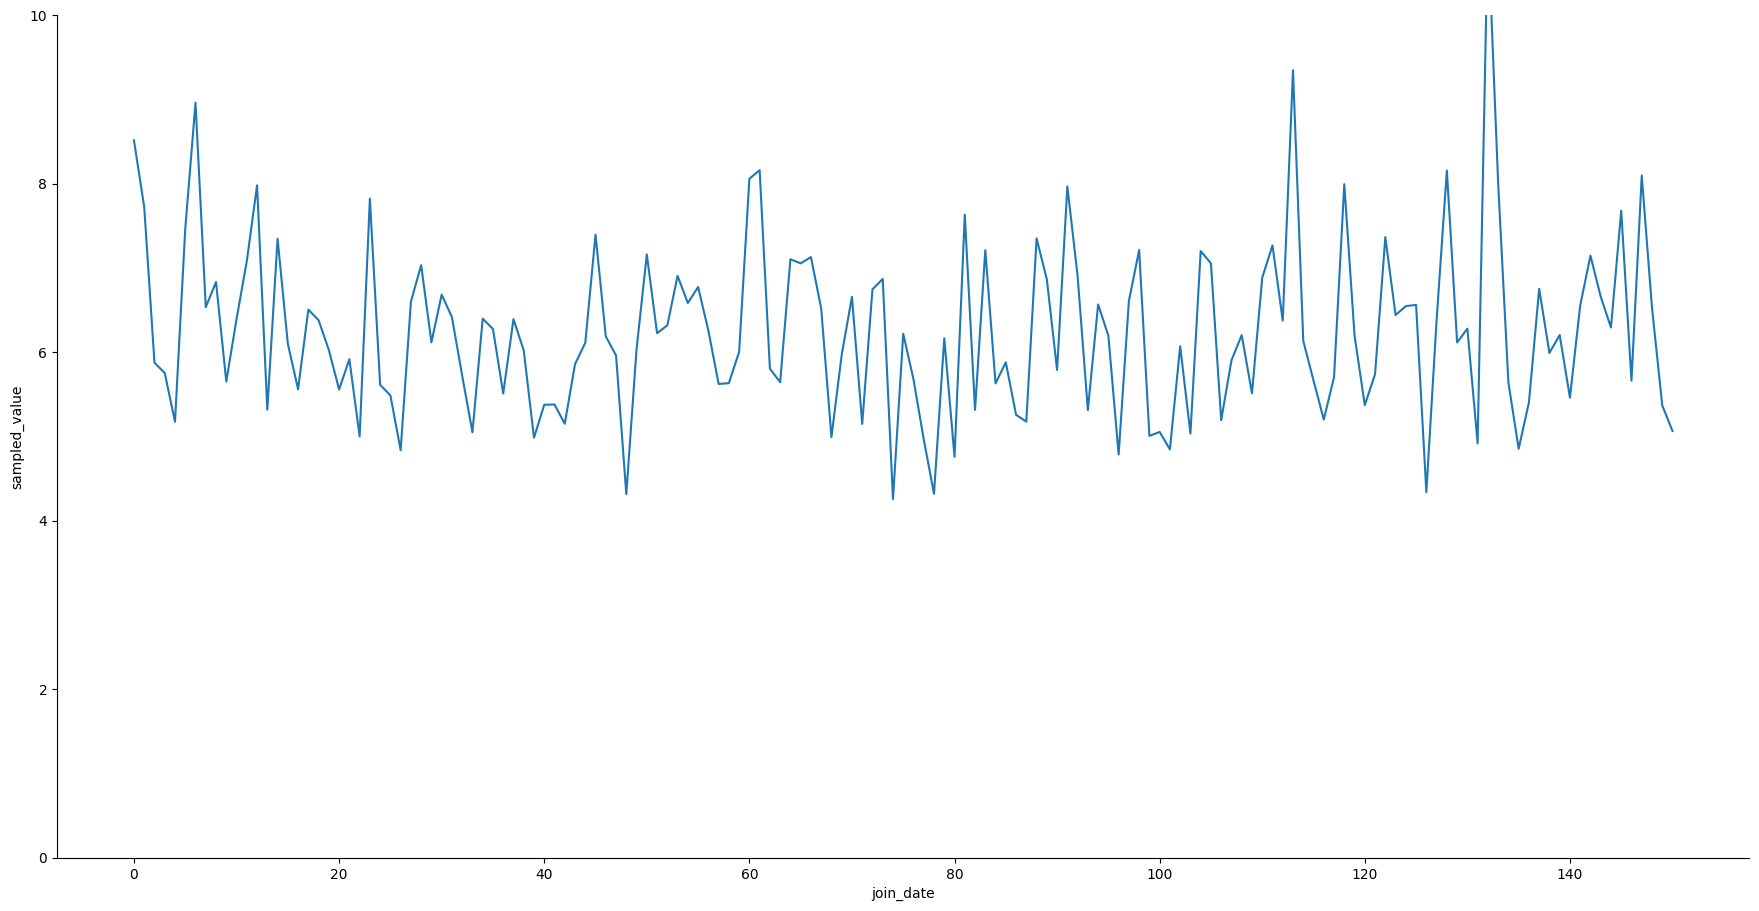

In [7]:
g = sns.relplot(time_series_data, x='join_date', y='sampled_value', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)
g.ax

## Using PyMC to model the time-series

In [8]:
# Create PyTensor equivalent
t_t = pytensor.shared(time_series_data['join_date'].values)
y_t = pytensor.shared(time_series_data['sampled_value'].values)
dev_t = pytensor.shared(time_series_data['sampled_stddev'].values**2)

In [9]:
# Define the coordinates for the time series
coords = {"steps": time_series_data['join_date'].values}
with pm.Model(coords=coords) as model:

    # Priors on Gaussian random walks
    alpha_prior = pm.Normal.dist(6, 3)
    alpha_dev = pm.HalfCauchy('alpha_dev', 2)
    alpha = pm.GaussianRandomWalk(
        "alpha", mu=0, sigma=alpha_dev, init_dist=alpha_prior, shape=n_days, dims="steps"
    )

    # Prior on noise ξ
    sigma = pm.HalfCauchy("sigma", 2, observed=dev_t, dims="steps")

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=alpha, sigma=sigma, observed=y_t, dims="steps")

    # MCMC sampling
    trace = pm.sample(1000, chains=4)

    


/home/tamaki/.local/lib/python3.10/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/tamaki/.local/lib/python3.10/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/tamaki/.local/lib/python3.10/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/tamaki/.local/lib/python3.10/site-packages/pymc/

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 554 seconds.


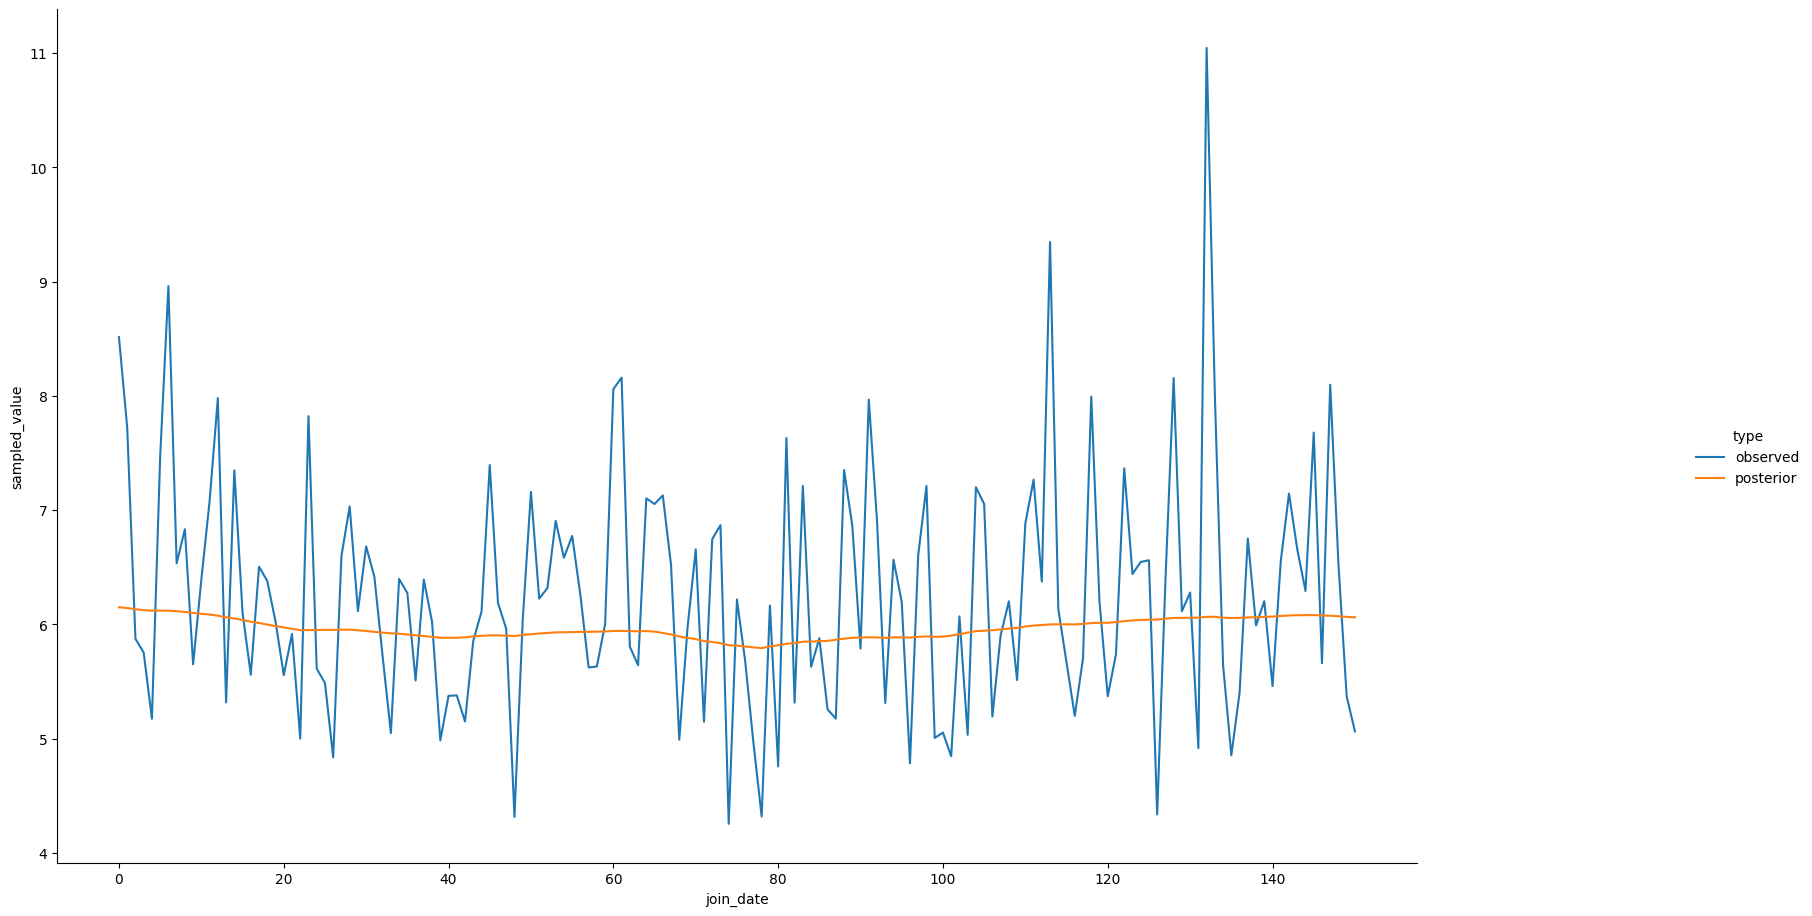

In [10]:
avgs = np.mean(np.mean(trace['posterior']['alpha'], axis=1), axis=0)
posterior_data = pd.DataFrame({"sampled_value": avgs, "join_date": time_series_data['join_date'].values}, columns=['sampled_value', 'join_date'])
posterior_data['type'] = 'posterior'

plot_data = time_series_data.copy()
plot_data = plot_data[['sampled_value', 'join_date']]
plot_data['type'] = 'observed'

plot_data = pd.concat([plot_data, posterior_data])

g = sns.relplot(plot_data, x='join_date', y='sampled_value', hue='type', kind='line')
g.figure.set_size_inches(20, 10)

## Repeat the same process, but on a synthetic data that has a 'stronger' random walk

In [11]:
from src import DataGenerator

date_start = datetime(2022, 1, 1)
date_end = datetime(2022, 7, 31)
n_days = (date_end - date_start).days

initial_value = 6
cov_matrix = 0.3
sampling_variance = 0.5 #1.5
seed = 40

time_series = DataGenerator.SingleLognormalTimeSeries(
    date_start,
    date_end,
    initial_value,
    cov_matrix,
    sampling_variance, 
    seed
)

time_series.generate_time_series()
synthetic_time_series_data = time_series.time_series_data
synthetic_time_series_data['ts'] = (synthetic_time_series_data['ts'] - date_start).dt.days.values
synthetic_time_series_data.head()

,ts,unknown_value,sampled_value,sampling_var
0,0,5.657372,4.350085,9.090478
1,1,5.336571,6.001402,8.088758
2,2,5.109394,4.989025,7.414741
3,3,5.339992,4.268406,8.099129
4,4,5.028611,7.567654,7.182130


In [12]:
# Create PyTensor equivalent
t_t = pytensor.shared(synthetic_time_series_data['ts'].values)
y_t = pytensor.shared(synthetic_time_series_data['sampled_value'].values)
dev_t = pytensor.shared(synthetic_time_series_data['sampling_var'].values)

In [25]:
# Define the coordinates for the time series
coords = {"steps": synthetic_time_series_data['ts'].values}
with pm.Model(coords=coords) as model:

    # Priors on Gaussian random walks
    alpha_prior = pm.Normal.dist(6, 3)
    alpha_dev = pm.Normal('alpha_dev', 0.1, 0.001) # basically constant
    alpha = pm.GaussianRandomWalk(
        "alpha", mu=0, sigma=alpha_dev, init_dist=alpha_prior, shape=synthetic_time_series_data.shape[0], dims="steps"
    )

    # Prior on noise ξ
    sigma = pm.HalfCauchy("sigma", 2, observed=dev_t, dims="steps")

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=alpha, sigma=sigma, observed=y_t, dims="steps")

    # MCMC sampling
    synthetic_trace = pm.sample(1000, chains=4)




Only 200 samples in chain.
/home/tamaki/.local/lib/python3.10/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/tamaki/.local/lib/python3.10/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/tamaki/.local/lib/python3.10/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/home/tamaki/.local/lib/pyt

Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 177 seconds.
/home/tamaki/.local/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


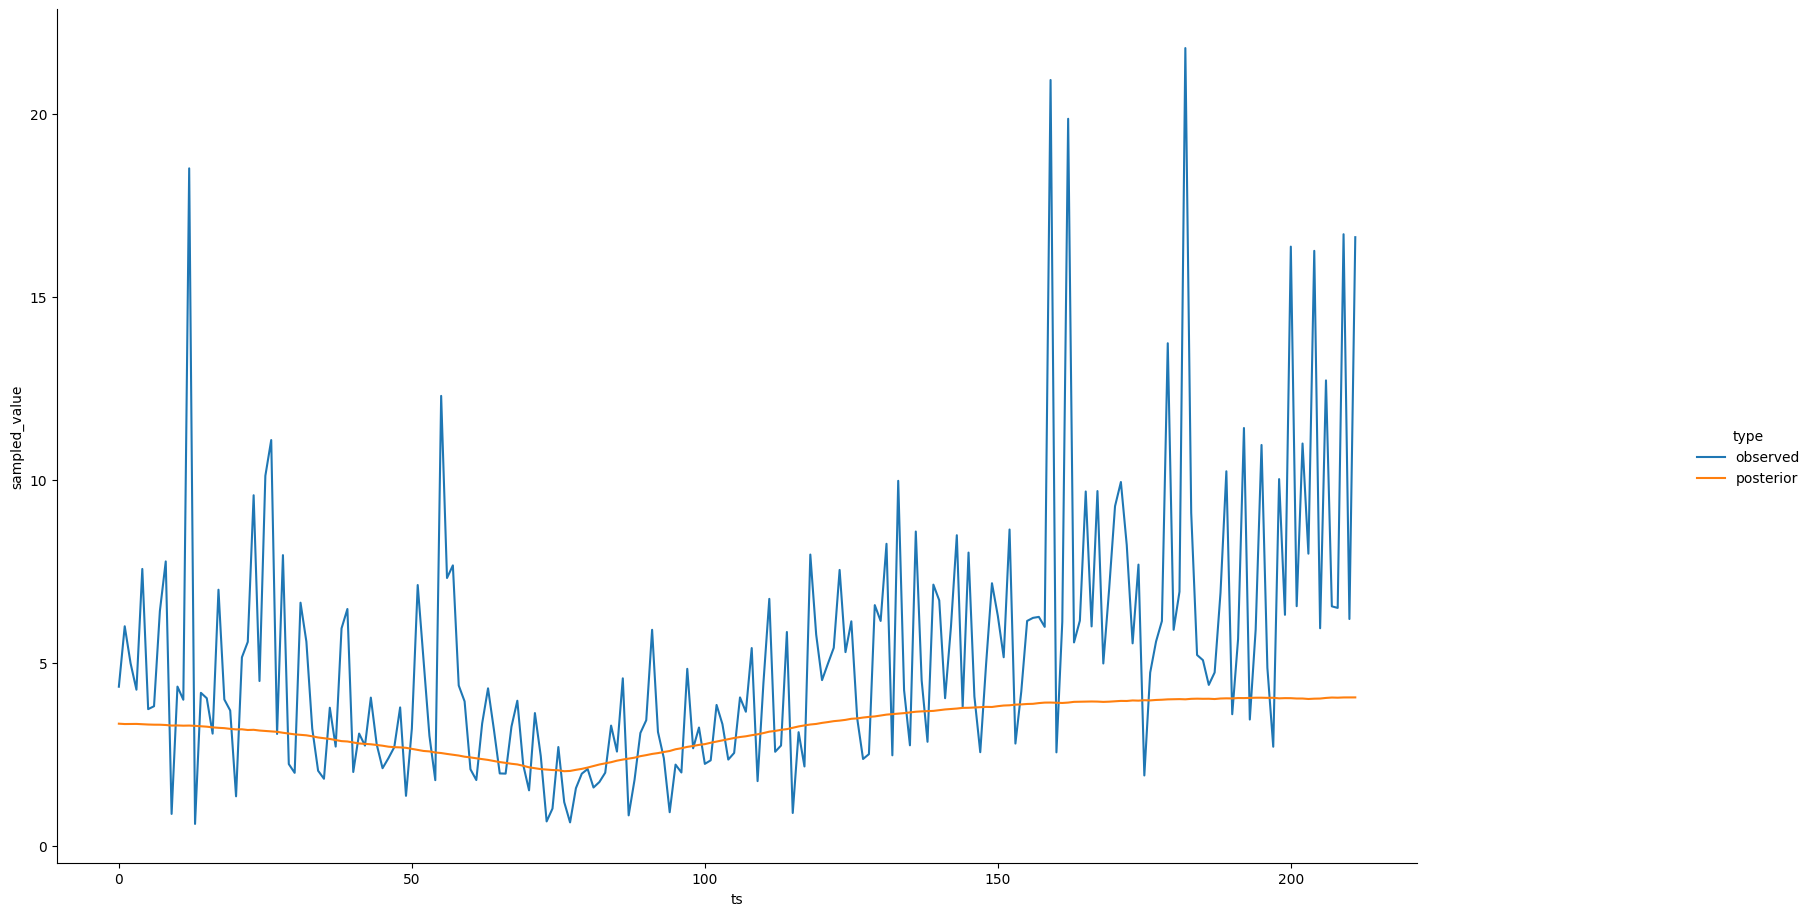

In [26]:
avgs = np.mean(np.mean(synthetic_trace['posterior']['alpha'], axis=1), axis=0)
posterior_data = pd.DataFrame({"sampled_value": avgs, "ts": synthetic_time_series_data['ts'].values}, columns=['sampled_value', 'ts'])
posterior_data['type'] = 'posterior'

plot_data = synthetic_time_series_data.copy()
plot_data = plot_data[['sampled_value', 'ts']]
plot_data['type'] = 'observed'

plot_data = pd.concat([plot_data, posterior_data])

g = sns.relplot(plot_data, x='ts', y='sampled_value', hue='type', kind='line')
g.figure.set_size_inches(20, 10)